# HOMEWORK 1
This is my first project which was given to me as an exercise for the Theoretical Astrophysics II: Polarized Radiative Transfer course at the university of Freiburg. The goal is to synthesize a spectral line profile in "Local Thermodynamic Equilibrium" from a given atmospheric model. 

To do this I am going to calculate level populations using the Boltzmann and Saha equations, compute line opacity, source function and solve the radiative transfer equation.

The atmospheric model is provided by the "falc.dat", which can be found in this repository.

In [23]:
# all needed imports
import numpy as np
import matplotlib.pyplot as plt 
from scipy import constants as con
from scipy.optimize import fsolve
from scipy.special import wofz

# data
continuum_optical_depth_500, height, temperature, gas_pressure, electron_pressure = np.loadtxt('falc_71.txt', usecols=(0,1,2,3,4), unpack=True)

<br><br>
### STEP 1: Solve for the ionization state

As a warm-up the Saha equation (only for Hydrogen) is used to compute the ionization state of Hydrogen as a function of height in the atmosphere. We will get the electron density and compare it with the one given in the model.

The Saha equation is given by:
$\frac{n_{j+1}n_e}{n_j} = \frac{2Z_{j+1}}{Z_j} \left(\frac{2 \pi m_e k T}{h^2} \right)^{\frac{3}{2}}e^{-\frac{E_j}{kT}}$

Let us define the right hand side as a new function: $f(T,p)=\frac{2Z_{j+1}}{Z_j} \left(\frac{2 \pi m_e k T}{h^2} \right)^{\frac{3}{2}}e^{-\frac{E_j}{kT}} \Longrightarrow \frac{n_{j+1}n_e}{n_j} = f(T,p)$ 

$\frac{n_{H^+}n_e}{n_H} = \frac{2Z_{H^+}}{Z_H} \left(\frac{2 \pi m_e k T}{h^2} \right)^{\frac{3}{2}}e^{-\frac{13.6eV}{kT}}$ with 

$n_{H^+} = n_e$

$n_H + n_{H^+} + n_e = n_{tot}$

$n_{tot} = \frac{p}{kT}$

$\Longrightarrow \frac{n_e^2}{n_{tot}-2n_e} = f(T,p) \Longleftrightarrow n_e^2 + 2n_e^2 f(T,p) - n_{tot}f(T,p) = 0$

The solution of this equation is given by: $n_e = -f(T,P)+ \sqrt{f^2(T,P) + n_{tot}f(T,P)}$

In [24]:
# now we implement the functions for the hydrogen atom
def solve_saha_H(p, T, Z_1, Z_2):
    
    # ideal gas law
    n_tot = p / con.k / T

    # function to calculate the electron density 
    f = 2 * Z_2/Z_1 * (2 * con.pi * con.electron_mass * con.k * T / con.h**2)**1.5 * np.exp(-13.6*con.electron_volt / con.k / T)

    # solution to the equation
    n_e = -f + (f**2 + n_tot*f)**0.5

    # number of ions
    n_HP = n_e

    # number of Hydrogen atoms
    n_H = n_tot - 2*n_e

    return n_e, n_H, n_HP


In [25]:
# now we calculate all densities with the values from the data
n_e_results = []
n_e_data = []

for i in range(len(gas_pressure)):
    n_e_results.append(solve_saha_H(gas_pressure[i]*0.1, temperature[i], 2, 1)[0])

for i in range(len(electron_pressure)):
    n_e_data.append(electron_pressure[i]*0.1 / con.k / temperature[i])


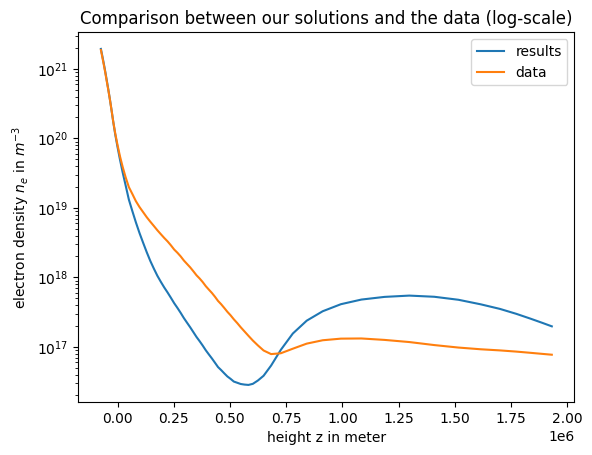

In [26]:
# now we plot the results:
plt.title('Comparison between our solutions and the data (log-scale)')
plt.xlabel('height z in meter')
plt.ylabel(r'electron density $n_e$ in $m^{-3}$')
plt.plot(0.01*height, n_e_results, label="results")
plt.plot(0.01*height, n_e_data, label="data")
plt.yscale('log')
plt.legend()
plt.show()

<br><br>
### STEP 2: Adding one more species

As we see, the error between our results and the data is getting bigger with the hight. To fix this, we need to add more species that contribute electrons.
The most important ones should be Magnesium and Iron. We will substitute both of them with a proto-model for Magnesium only.

Since we now have more species, we get more equation which we have to solve:

1. $\frac{n_{H^+}n_e}{n_H} = \frac{2Z_{H^+}}{Z_H} \left(\frac{2 \pi m_e k T}{h^2} \right)^{\frac{3}{2}}e^{-\frac{13.6eV}{kT}} = f_1(T,p)$
<br><br>
2. $\frac{n_{MgII}n_e}{n_{MgI}} = \frac{2Z_{MgII}}{Z_{MgI}} \left(\frac{2 \pi m_e k T}{h^2} \right)^{\frac{3}{2}}e^{-\frac{7.646eV}{kT}} = f_2(T,p)$
<br><br>
3. $n_H + n_{H^{+}} + n_{MgI} + n_{MgII} = n_{tot} = \frac{p}{kT}$ (Abundance of Magnesium very small)
<br><br>
4. Abundance of Magnesium: $n_{MgI} + n_{MgII} =  7.6 \times 10^{-5} n_{tot}$
<br><br>
5. $n_e = n_{H^+} + n_{MgII}$ 
<br><br>
for the partition functions we use: $Z_{MgI} = 2$ and $Z_{MgII} = 1$

In [27]:
# now we implement the functions for Magnesium atom
def solve_saha_MgI(p, T, Z_1, Z_2):
    
    # ideal gas law
    n_tot = p / con.k / T * 7.6E-5

    # function to calculate the electron density 
    f = 2 * Z_2/Z_1 * (2 * con.pi * con.electron_mass * con.k * T / con.h**2)**1.5 * np.exp(-7.646*con.electron_volt / con.k / T)

    # solution to the equation
    n_e = -f + (f**2 + n_tot*f)**0.5

    # number of ions
    n_HP = n_e

    # number of Hydrogen atoms
    n_H = n_tot - 2*n_e

    return n_e, n_H, n_HP

In [28]:
# define Saha equation:
def saha_equation(T, Z_1, Z_2, E_ion):
    return 2 * Z_2/Z_1 * (2 * con.pi * con.electron_mass * con.k * T / con.h**2)**1.5 * np.exp(-E_ion*con.electron_volt / con.k / T)

def solve_system(T, p):
    # calculate n_tot:
    n_tot = p / con.k / T

    # define Saha equations for our species:
    f_1 = saha_equation(T, 2, 1, 13.6) # Hydrogen -> Hydrogen+
    f_2 = saha_equation(T, 2, 1, 7.646) # MagnesiumI -> MagnesiumII

    # define vector, which we want to solve:
    def equations(vars):
        n_e, n_H, n_HP, n_MgI, n_MgII = vars
        return[
            n_HP*n_e/n_H - f_1, # Saha for Hydrogen -> Hydrogen+
            n_MgII*n_e/n_MgI - f_2, # Saha for MagnesiumI -> MagnesiumII
            n_H + n_HP + n_MgI + n_MgII + n_e - n_tot, # total number of particles
            n_MgI + n_MgII - 7.6E-5*(n_H + n_HP), # total number of Magnesium particles
            n_HP + n_MgII - n_e # charge neutrality 
        ]

    # safe results from Saha
    bla1 = solve_saha_H(p, T, 1, 2)
    bla2 = solve_saha_MgI(p,T, 2, 1)

    # initial guess
    x_0 = [bla1[0] + bla2[0], bla1[1], bla1[2], bla2[1], bla2[2]]

    solutions = fsolve(equations, x_0)

    n_e = solutions[0]
    n_MgI = solutions[3]

    return n_e, n_MgI


In [29]:
# saving results
n_e_results = [solve_system(temperature[i], gas_pressure[i]*0.1)[0] for i in range(len(gas_pressure))]

C:\Users\Damian\AppData\Local\Temp\ipykernel_28908\3142068043.py:31: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  solutions = fsolve(equations, x_0)
C:\Users\Damian\AppData\Local\Temp\ipykernel_28908\3142068043.py:31: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  solutions = fsolve(equations, x_0)


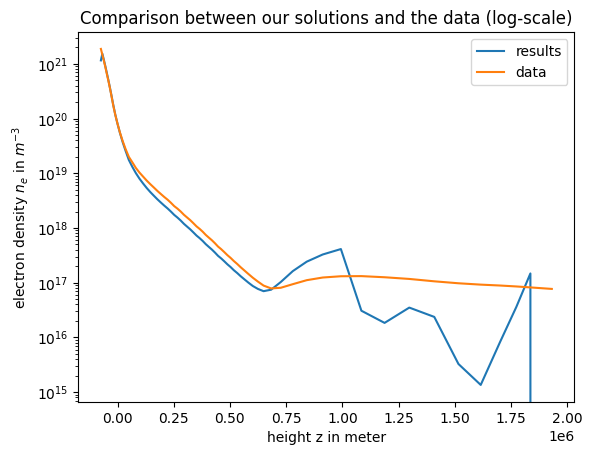

In [30]:
# now we plot the results:
plt.title('Comparison between our solutions and the data (log-scale)')
plt.xlabel('height z in meter')
plt.ylabel(r'electron density $n_e$ in $m^{-3}$')
plt.plot(0.01*height, n_e_results, label="results")
plt.plot(0.01*height, n_e_data, label="data")
plt.yscale('log')
plt.legend()
plt.show()

<br><br>
### STEP 3: Calculate Level Populations

We are going to synthesize the Magnesium MgIb2 Line at 517.2 nm.
For this, we only need the energies of the level and their statistical weights given by $g = 2J+1$
In the case of the Magnesium line $g$ is given by $g = 2\cdot1+1 = 3$

To calculate level population of each level we are going to use the Boltzmann equation: $n_{j,i} = \frac{n_j g_i}{Z_i(T)}e^{-\frac{E_i}{k_B T}}$
<br><br>
In our case we get the two equations:
<br><br>
$n_l = \frac{3n_{MgI}}{2}e^{-\frac{2.7115919eV}{k_BT}}$ and $n_u = \frac{3n_{MgI}}{2}e^{-\frac{5.1078270eV}{k_BT}}$

In [31]:
# array with all n_MgI
n_MgI_results = [(solve_system(temperature[i], gas_pressure[i]*0.1)[1]) for i in range(len(gas_pressure))]

# define function to calculate the level populations
def calculate_level(n_MgI, T, E):
    return 3*n_MgI/2 * np.exp(-E*con.electron_volt / con.k / T)

# calculation of the lower level:
n_MgI_lower = [calculate_level(n_MgI_results[i], temperature[i], 2.7115919) for i in range(len(gas_pressure))]

# calculation of the upper level:
n_MgI_upper = [calculate_level(n_MgI_results[i], temperature[i], 5.1078270) for i in range(len(gas_pressure))]

C:\Users\Damian\AppData\Local\Temp\ipykernel_28908\3142068043.py:31: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  solutions = fsolve(equations, x_0)
C:\Users\Damian\AppData\Local\Temp\ipykernel_28908\3142068043.py:31: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  solutions = fsolve(equations, x_0)


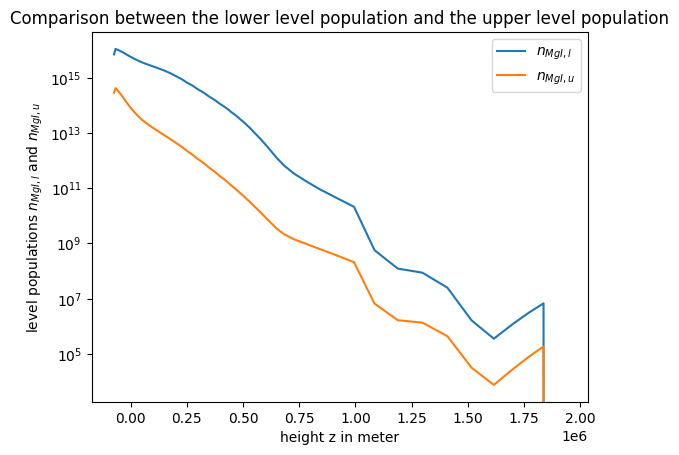

In [32]:
# now we plot the results:
plt.title('Comparison between the lower level population and the upper level population')
plt.xlabel('height z in meter')
plt.ylabel(r'level populations $n_{MgI,l}$ and $n_{MgI,u}$')
plt.plot(0.01*height, n_MgI_lower, label=r'$n_{MgI,l}$')
plt.plot(0.01*height, n_MgI_upper, label=r'$n_{MgI,u}$')
plt.yscale('log')
plt.legend()
plt.show()

<br><br>
### STEP 4: Calculate Line Opacity and Source Function

We assume a LTE, in this case the source function is just the Planck function and we focus on the opacity given by:
<br>
$\chi_\nu = \left( n_l B_{lu} - n_u B_{ul} \right) \frac{h \nu}{4 \pi} \phi(\nu)$
<br><br>
with: $n_l = n_{MgI,l}, n_u = n_{MgI,u}, $ Einstein coefficients $B_{lu}$ and $B_{ul}$ and the $\phi(\nu)$ the line profile.
<br><br>
The task is now to calculate the Einsein coefficients. To do this we need to use a third Einstein coefficient, which we get from NIST website.
<br>
In our case this coefficient is given by: $A_{ul} = 3.46\times 10^{-5} \frac{1}{s}$

For $B_{ul}$ we use: $B_{ul} = \frac{c^2}{2h\nu^3}A_{ul}$ and for $B_{lu} = \frac{g_u}{g_l}B_{ul} = B_{ul}$

In [11]:
# Calculation of the Einstein coefficients
A_ul = 3.46E7
B_ul = con.speed_of_light**2 / 2 / con.h / (5.7956*10**14)**3 * A_ul
B_lu = B_ul

<br><br>
### STEP 5: Calculate the line profile

Now we pick a wavelength range. We are going to calculate the line profile at each depth (2D-array depth vs. wavelength).

For this we will work through the following steps:

1. Calculate the Doppler width from the Magnesium atomic mass and temperature at each depth

2. Calculate the damping frequency (constant value for $A_{ul}$)

3. Convert the wavelength grid to dimensionless frequency offset $u = (\nu - \nu_0) / \Delta \nu_D$ and convert damping to $a = \Gamma / (4 \pi \Delta \nu_D)$ 

4. Calculate the Voigt profile $\phi(\nu)$ at each depth and wavelength point

Finally we are able to calculate the line opacity everywhere, at each depth and wavelength/frequency point:
$\chi_\nu = (n_l B_{lu} - n_u B_{ul}) \frac{h \nu}{4 \pi} \phi(\nu)$



In [40]:
lambda_0 = 517.2E-9 # wavelength of our spectral line in m
nu_0 = con.c / lambda_0 # frequency in Hz

# function which calculates the Doppler width
def dopplerwidth(T):
    m = 4.0359398E-26
    return nu_0 / con.c * np.sqrt(2 * con.k * T / m)
    
# wavelength and frequency grid
wave_grid = np.linspace(517E-9, 517.4E-9, 2000)
frequency_grid = con.c / wave_grid

# function for the frequency-offset
def offset(nu, width):
    return (nu - nu_0) / width

# damping parameter
def damping_parameter(width):
    return A_ul / 4 / np.pi / width


In [41]:
# calculation of the Doppler width for every temperature from the data
dopplerwidth_list = [dopplerwidth(temperature[i]) for i in range(len(gas_pressure))]

# calculation of the damping parameter
damping_list = [damping_parameter(dopplerwidth_list[i]) for i in range(len(dopplerwidth_list))]

# offset grid
u_grid = np.zeros((len(height), len(frequency_grid)))

for i in range(len(height)):
    width = dopplerwidth_list[i]
    u_grid[i, :] = offset(frequency_grid, width)

# damping grid
a_grid = np.zeros((len(height), len(frequency_grid)))

for i in range(len(height)):
    a_value = damping_list[i]
    a_grid[i, :] = a_value

# Voigt profile
def voigt_profile(a, u):
    return np.real(wofz(u + 1j * a)) / np.sqrt(np.pi)

# everything needed for phi
phi = np.zeros((len(height), len(frequency_grid)))

for i in range(len(height)):
    width = dopplerwidth_list[i]
    a = damping_list[i]
    u = u_grid[i, :]
    H = voigt_profile(a, u)
    phi[i, :] = H / (width * np.sqrt(np.pi))

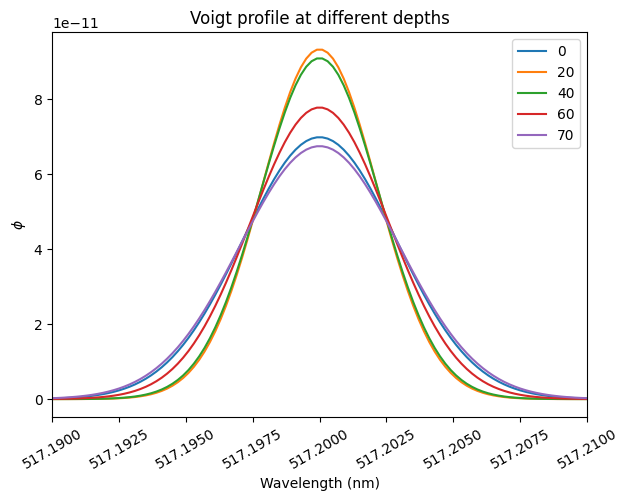

In [42]:
# quick check for the Voigt profile
depth_index = [0, 20, 40, 60, 70]
for depth in depth_index:
    plt.plot(wave_grid*1E9, phi[depth, :], label = depth)
plt.xlabel("Wavelength (nm)")
plt.ylabel(r'$\phi$')
plt.xlim(517.19, 517.21)
plt.title("Voigt profile at different depths")
plt.tight_layout()
plt.xticks(rotation=30)
plt.legend()
plt.show()

In [ ]:
# chi function
chi = np.zeros((len(height), len(frequency_grid)))

# calculation of the values for chi
for i in range(len(height)):           
    for j in range(len(frequency_grid)):  
        
        prefactor = (n_MgI_lower[i] * B_lu - n_MgI_upper[i] * B_ul) 
        
        chi[i, j] = prefactor * (con.h * frequency_grid[j] / (4 * np.pi)) * phi[i, j]

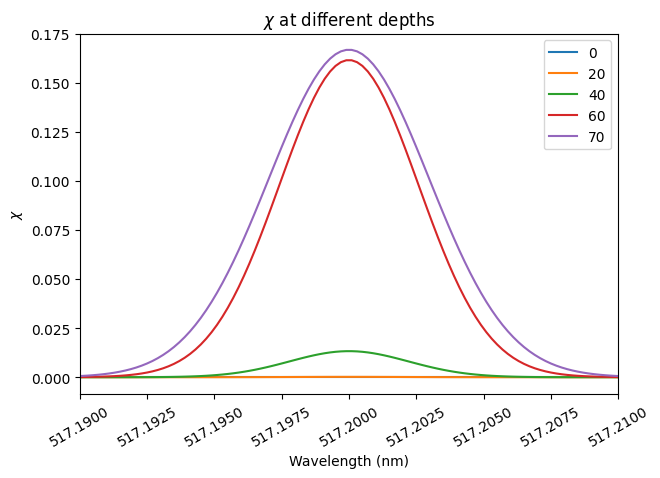

In [45]:
# quick check for chi
depth_index = [0, 20, 40, 60, 70]
for depth in depth_index:
    plt.plot(wave_grid*1E9, chi[depth, :], label = depth)
plt.xlabel("Wavelength (nm)")
plt.ylabel(r"$\chi$")
plt.title(r"$\chi$ at different depths")
plt.xticks(rotation=30)
plt.tight_layout()
plt.xlim(517.19, 517.21)
plt.legend()
plt.show()

In [46]:
# array with the step difference (height difference)
height_step = [-1E-2*height[i+1] + 1E-2*height[i] for i in range(len(height)-1)]

# calculate tau_line
tau_line = np.zeros((len(height), len(frequency_grid)))

# integration for each frequency and height
for i in range (len(frequency_grid)):
    tau = 0
    tau_line[0, i] = 0
    
    for j in range(1, len(height), 1):
        avg_chi = 0.5 * (chi[j, i] + chi[j-1, i])
        tau_line[j, i] = tau_line[j-1, i] + avg_chi * height_step[j-1]

# continuum optical depth
tau_cont_500 = 10 ** continuum_optical_depth_500

# array for contiunuum depth
tau_cont = np.zeros((len(height), len(frequency_grid)))
for i in range(len(height)):
    for j in range(len(frequency_grid)):
        tau_cont[i, j] = tau_cont_500[i]

# total optical depth
tau_total = tau_line + tau_cont 

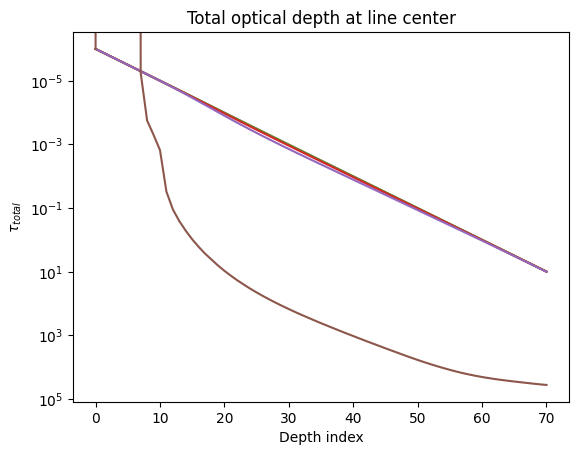

In [39]:
lambda0 = 517.2
idx_center = np.argmin(np.abs(wave_grid - lambda0))
plt.gca().invert_yaxis()

plt.semilogy(tau_total[:, 0])
plt.semilogy(tau_total[:, 200])
plt.semilogy(tau_total[:, 400])
plt.semilogy(tau_total[:, 600])
plt.semilogy(tau_total[:, 800])
plt.semilogy(tau_total[:, 1000])

plt.xlabel("Depth index")
plt.ylabel(r"$\tau_{total}$")
plt.title("Total optical depth at line center")
plt.show()

<br><br>
### STEP 7: Integrate the transfer equation

We finally have: $\frac{dI_\nu}{d\tau_\nu} = I_\nu - S_\nu$

Now we use: $I(\tau_1) = I(\tau_2)e^{-(\tau_2 - \tau_1)} + \int_{\tau_1}^{\tau_2} S(\tau)e^{-(\tau - \tau_1)}d\tau$

We start at the bottom and set: $I_\nu(\tau_{\nu, max}) = B_\nu(T(\tau_{\nu, max}))$

And then step by step calculate $I_\nu$ at each depth, until we reached the top of the atmosphere.

To move step by step, we use: $I(\tau_{i+1})e^{-(\tau_{i+1} - \tau_i)} + S(\tau_i)(1-e^{-(\tau_{i+1}-\tau_i)})$



In [19]:
def planck(frequency, temperature):
    return 2 * con.h * frequency**3 / con.c**2 / (np.exp(con.h * frequency / con.k / temperature) - 1)

In [20]:
S = np.zeros((len(height), len(frequency_grid)))
for j in range(len(height)):
    for i in range(len(frequency_grid)):
        S[j, i] = planck(frequency_grid[i], temperature[j])

In [21]:
n_z, n_nu = tau_total.shape

I = np.zeros((n_z, n_nu))

# Startvalue at bottom
for i in range(n_nu):
    I[-1, i] = S[-1, i]

# Integration to the top
for j in range(n_z-2, -1, -1):        
    for i in range(n_nu):             
        dtau = tau_total[j+1, i] - tau_total[j, i]
        e = np.exp(-dtau)
        I[j, i] = I[j+1, i] * e + S[j, i] * (1 - e)

# Intensity at the top
Intensity = I[0, :]

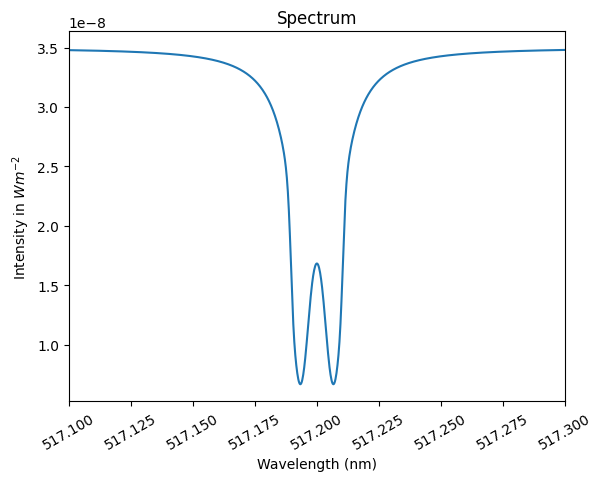

In [22]:
plt.plot(wave_grid*1e9, Intensity)
plt.xlabel("Wavelength (nm)")
plt.ylabel(r"Intensity in $Wm^{-2}$")
plt.title("Spectrum")
plt.xticks(rotation=30)
plt.xlim(517.1, 517.3)
plt.show()